## Exercise



**1 - import the [pendulum](https://www.gymlibrary.ml/environments/classic_control/pendulum/) and show it with a random policy (hint: use the action space.sample() method of the environment)** 

In [42]:
# It works with gym version 0.20.0
import gym
env = gym.make('Acrobot-v1');

In [43]:
import matplotlib.pyplot as plt
from IPython import display

def show_environment(env, steps=100):
    plt.axis('off')
    observation = env.reset()
    done = False
    for _ in range(steps): 
        action = env.action_space.sample()
        _, _, done, _ = env.step(action)
        if done: 
            observation, info = env.reset()
        display.clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array'))
        plt.show()   
    env.close()
    return

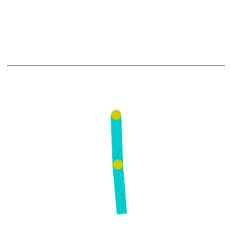

In [44]:
show_environment(env, steps=200)

**2 - train a NFQ agent to solve the control problem**

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

In [24]:
class EGreedyStrategy():
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [25]:
class GreedyStrategy():
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

In [26]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 seed, batch_size, epochs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        # get the values of the Q-function at next state 
        q_sp = self.model(next_states).detach()
        
        # get the max value of the next state
        # unsqueeze adds a dimension to the vector so the 
        # operations that follow work on the correct elements
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        
        # one important step, often overlooked, is to ensure 
        # terminal states are grounded to zero
        max_a_q_sp *= (1 - is_terminals)
        
        # calculate the target 
        target_q_sa = rewards + self.gamma * max_a_q_sp
        
        # finally, we get the current estimate of Q(s,a)
        q_sa = self.model(states).gather(1, actions)

        # create the errors
        td_errors = q_sa - target_q_sa
        
        # calculate the loss, and optimize the online network
        value_loss = td_errors.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):
        action = self.train_strategy.select_action(self.model, state)
        
        # collect an experience tuple as usual
        new_state, reward, is_terminal, info = self.env.step(action)
        
        # check for the key TimeLimit.truncated
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        
        # so a failure is defined as follows
        is_failure = is_terminal and not is_truncated
        
        # add the terminal flag if the episode ended in failure
        # if it isn’t a failure, we want to bootstrap on the value of the new_state 
        experience = (state, action, reward, new_state, float(is_failure))

        self.experiences.append(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        training_start = time.time()
        last_debug_time = float('-inf')

        self.gamma = gamma
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
    
        self.experiences = []

        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state)
                
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(self.experiences, dtype=object)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.model.load(batches)
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                    self.experiences.clear()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
            
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print('--> reached_max_minutes')
                if reached_max_episodes: print('--> reached_max_episodes')
                if reached_goal_mean_reward: print('--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(self.model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

In [28]:
gamma = 0.99
max_minutes = 20
max_episodes = 1000
goal_mean_100_reward = 10

batch_size = 1024
epochs = 40
seed = 12

nS, nA = env.observation_space.shape[0], env.action_space.n

print('Training started...')

model = FCQ(nS, nA, hidden_dims=(512,128))
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
train_strategy = EGreedyStrategy(epsilon=0.5)
eval_strategy = GreedyStrategy()
    
agent = NFQ(env, model, optimizer, train_strategy, eval_strategy, seed, batch_size, epochs)
result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_mean_100_reward)
    
print('...training complete.')
print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
        .format(score, score_std, training_time))

Training started...
episode 0000, steps 000500, avg score -500.0±000.0, 
episode 0363, steps 064594, avg score -162.0±032.6, 
episode 0710, steps 123015, avg score -166.2±039.0, 
episode 0999, steps 170559, avg score -160.9±057.5, 
--> reached_max_episodes
...training complete.
Final evaluation score -86.74±18.38 in 134.01s training time



**3 - show the learning curves** 

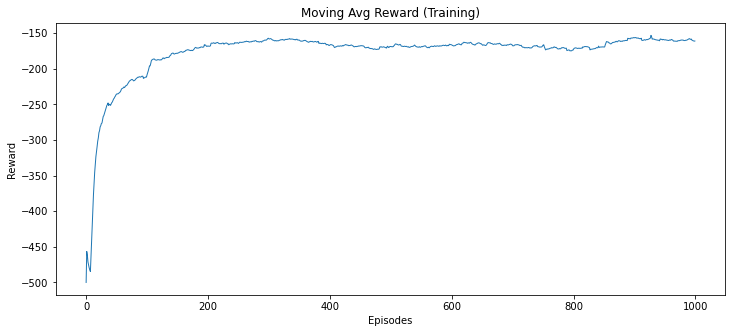

In [29]:
import matplotlib.pyplot as plt

steps, train_reward, eval_score, time = result.T

plt.figure(figsize=(12,5))
plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

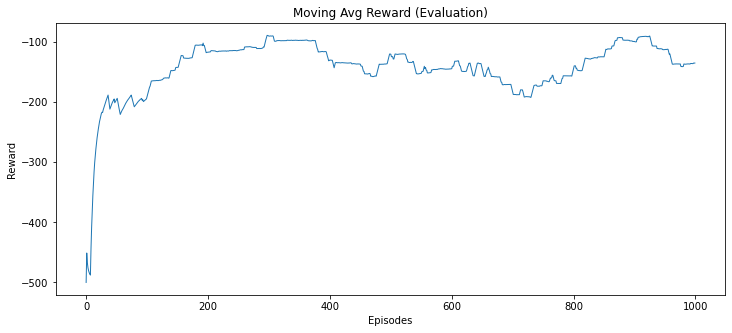

In [30]:
plt.figure(figsize=(12,5))
plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

**4 - show the policy behaviour**

In [40]:
def show_policy(agent, env, steps=100):
    plt.axis('off')
    observation = env.reset()
    done = False
    for _ in range(steps): 
        action = agent.eval_strategy.select_action(agent.model, observation)
        observation, _, done, _ = env.step(action)
        if done: 
            observation = env.reset()
        display.clear_output(wait=True)
        plt.axis('off')
        plt.imshow(env.render(mode='rgb_array'))
        plt.show()   
    env.close()
    return

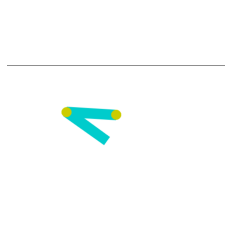

In [41]:
env = gym.make('Acrobot-v1');
show_policy(agent, env, steps=200)